# song2movie - Light
### 曲を(比較的)簡単に動画に変換するプログラムの更に簡易版
1. 左のタブからフォルダアイコンを選択、楽曲ファイル(あれば画像ファイルも)をドラッグ&ドロップ  
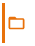

  *「ファイルのブラウジングを有効に~~」と表示されている場合は、フォルダアイコンを二度クリックしてしばらく待てば上記画像の状態になります。
2. 左下のアップロード状況を確認し、アップロードが完了した(アップロード時に現れる画像の円グラフが消えた)のを確認
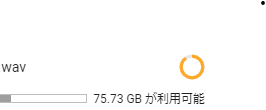

3. 必要ならタイトルなどを記入後、↓のセルを実行すると曲動画を作成しダウンロードする事ができます。  



---



---



In [ ]:
#@title **↓の設定を記入後、←の再生ボタンをクリック**

#@markdown ***楽曲タイトル*** 不要ならば空白でOK
title = "" #@param {type:"string"}

#@markdown ***アーティスト名*** 不要ならば空白でOK
artist = "" #@param {type:"string"}

#@markdown ***動画長さ(秒)***  *0で楽曲ファイルと同じ秒数
length =   0#@param {type:"number"}

start = 0

spectrum_figure = "線"
figs = {"線":"line","点":"rect","無し":"None"}
sfig = figs[spectrum_figure]

transparency = 0.5

#@markdown ***フェードイン|アウト***
fading = False #@param {type:"boolean"}

fadein = fading

fadeout = fading

fade_time =  2

#@markdown ***文字色*** 背景色は文字色の反対になります
color = "white" #@param ["black","white"]

bgcolor = "black" if color == "white" else "white"

#@markdown ***フォント***
_font = "明朝 細字" #@param ["明朝 細字","明朝 中字","明朝 太字","ゴシック 細字","ゴシック 中字","ゴシック 太字"]
fonts =  {"明朝 細字":"SourceHanSerifJP-ExtraLight.otf",
         "明朝 中字":"SourceHanSerifJP-Medium.otf",
         "明朝 太字":"SourceHanSerifJP-Bold.otf",
         "ゴシック 細字":"mplus-2c-thin.ttf",
         "ゴシック 中字":"mplus-2c-regular.ttf",
         "ゴシック 太字":"mplus-2c-heavy.ttf"}
fontpath = fonts[_font]
#@markdown フォント参考画像：

fps = 30.0

size = "1080p"



!pip install pydub sh
!if [ ! -e ffpb.py ];then wget -q https://github.com/nankasuisui/song2movie/raw/main/ffpb.py; fi
import ffpb,sys
from tqdm.notebook import tqdm
import numpy as np
import librosa,pydub
import cv2 as cv
from PIL import ImageFont, ImageDraw, Image
from pydub import AudioSegment
import subprocess,os
import glob
import copy
from math import ceil
from google.colab import files
from google.colab import output
import progressbar

if not os.path.isfile(fontpath):
  font_family = fontpath.split('-')[0]
  !wget -q https://github.com/nankasuisui/song2movie/raw/main/fonts/$font_family/$fontpath


song_extension = ["wav","WAV","mp3","MP3","ogg","OGG","m4a","M4A","flac","FLAC"]
for ext in song_extension:
  song = glob.glob("/content/*."+ext)
  if len(song) != 0:
    break
if len(song) == 0:
  print("Song not found.")
  song = None
else:
  song = song[0]

image_extension = ["jpg","JPG","png","PNG","bmp","BMP","gif","GIF","tiff","TIFF"]
for ext in image_extension:
  image = glob.glob("/content/*."+ext)
  if len(image) != 0:
    break
if len(image) == 0:
  print("Image not found. use plane bg.")
  image = None
else:
  image = image[0]
  if not (os.path.isfile(image)):
    print("invalid image file.")

if not (os.path.isfile(song)):
    print("invalid song file.")
    exit()

  
#fn = os.path.splitext(os.path.basename(song))[0]
#video = str(fn)+".mp4"
video = "out.mp4"


#define functions
def sigmoid(x,a):
    return 1.0 / (1.0 + np.exp(-x*a))

def norm(t,start,end,nstart,nend):
    return (t - start) * (nend - nstart) / (end - start) + nstart

def sig(t,start,end,sigrange,a=1): #start,end = timeのstart,end / sigrange = 正規化範囲(+-sigrangeになる)
    nt = norm(t,start,end,-sigrange,sigrange)
    return sigmoid(nt,a)

def puttext_ja(cv_image, text, point, font_path, font_size, color):
    font = ImageFont.truetype(font_path, font_size)

    cv_rgb_image = cv.cvtColor(cv_image, cv.COLOR_BGR2RGB)
    pil_image = Image.fromarray(cv_rgb_image)

    draw = ImageDraw.Draw(pil_image)
    draw.text(point, text, fill=color, font=font)

    cv_rgb_result_image = np.asarray(pil_image)
    cv_bgr_result_image = cv.cvtColor(cv_rgb_result_image, cv.COLOR_RGB2BGR)

    return cv_bgr_result_image

def resize_trim(img, target_width, target_height):
    h,w = img.shape[:2]
    scale_w = float(target_width) / w
    scale_h = float(target_height) / h
    scale = max([scale_w,scale_h])
    x = ceil(scale * w)
    y = ceil(scale * h)
    #img = cv.resize(img,fx=scale,fy=scale,dsize=(0,0))
    imgg = cv.resize(img,dsize=(x,y))
    return imgg[0:target_height,0:target_width]


    #load audio file
try:
    dubclip = AudioSegment.from_file(song,format=song[-3:])
except Exception as e:
    print("unexpected song format.",song[-3:])
    exit()

#check duration >= length
if length != 0 and dubclip.duration_seconds < length:
    print("song is shorter than expected length.")
    exit()

if length == 0:
    print("length not specified. use song duration.")
    length = dubclip.duration_seconds - start
    
    
#clip audio
dubclip = dubclip[start*1000:]
dubclip = dubclip[:length*1000]

#fade audio
if fadein:dubclip = dubclip.fade(from_gain=-np.inf, duration=fade_time*1000, start=0)
if fadeout:dubclip = dubclip.fade(to_gain=-np.inf, duration=fade_time*1000, end=float('inf'))

dubclip.export("tmp.wav",format="wav")

#load spectrums
y,sr = librosa.load("tmp.wav",sr=None,mono=False)
y = librosa.core.to_mono(y) #from stereo to mono for simplicity
y = librosa.util.normalize(y)
spec = librosa.feature.melspectrogram(y=y,sr=sr,hop_length=int(sr*1/fps),power=2.0,norm=1,n_mels=64)
spec = librosa.power_to_db(spec)

#normalize spectrums
spec = norm(spec,np.min(spec),np.max(spec),0,255).astype(np.uint8)
#plt.imshow(spec,origin='lower')


#draw
drawsize = {"720p":(1280,720),"1080p":(1920,1080),"480p":(640,480)}
writer = cv.VideoWriter("tmp.avi",0,fps,drawsize[size])

bg_bk = lambda: np.zeros((drawsize["1080p"][1],drawsize["1080p"][0],3),dtype=np.uint8)
bg_wh = lambda: np.full((drawsize["1080p"][1],drawsize["1080p"][0],3),255,dtype=np.uint8)

col_ = {"black":(0,0,0),"white":(255,255,255)}

if bgcolor == "black":
    bg_ = bg_bk
elif bgcolor == "white":
    bg_ = bg_wh

bg_img = bg_

if image:
    img = cv.imread(image)
    if img is None:
        print("image can't be loaded.")
    else:
        img = resize_trim(img,drawsize["1080p"][0],drawsize["1080p"][1])
        bg_img = lambda: img.copy()

#for f in range(int(length*fps)):
for f in progressbar.progressbar(range(int(length*fps))):
    #output.clear()
    #print("rendering: {} / {}".format(f,int(length*fps)))
    #background
    frame = bg_img()
    
    #spectrum
    if sfig == "rect":
        #ver.rectangle
        for i,n in enumerate(spec[:,f]):
            for h in range(int(norm(n,0,255,0,24))):
                cv.rectangle(frame, (80+i*28,800-h*20),(80+i*28+14,800-h*20-14),col_[color], -1, cv.LINE_AA)
                
    elif sfig == "line":
        #ver.line
        for i,n in enumerate(spec[:,f]):
            cv.line(frame,(80+i*28,800),(80+i*28,800-int(2.7*n)),col_[color],10,cv.LINE_AA)
    
    # spectrum transparency
    if image and not img is None:
      frame = cv.addWeighted(frame,transparency,bg_img(),1.0-transparency,0)

    #text
    ## title
    frame = puttext_ja(frame,title,(80,800),fontpath,130,col_[color])
    ## artist
    frame = puttext_ja(frame,artist,(100,940),fontpath,70,col_[color])


    #fadein
    if fadein:
        if f < fade_time*fps:
            alpha = sig(f,0,fade_time*fps,2,2) if f != 0 else 0
            frame = cv.addWeighted(frame,alpha,bg_(),1.0-alpha,0)
    
    #fadeout
    if fadeout:
        if f >= length*fps-1 - fade_time*fps:
            alpha = sig(f,length*fps-1,length*fps-1 - fade_time*fps,2,2) if f != length*fps-1 else 0
            frame = cv.addWeighted(frame,alpha,bg_(),1.0-alpha,0)
        
    #resize
    if size == "1080p":
        pass
    elif size == "720p":
        frame = cv.resize(frame,(1280,720))
    elif size == "480p":
        frame = cv.resize(frame,(854,480))

    writer.write(frame)
    
writer.release()



#save
#cmd = "ffmpeg -y -i {} -i {} {} {} -v error -flags global_header {}".format("tmp.avi","tmp.wav","-vcodec h264 -pix_fmt yuv420p -r",fps,video)
#!$cmd
ffpb.ffmpeg(argv=["-y",
             "-i","tmp.avi",
             "-i","tmp.wav",
             "-vcodec","h264",
             "-pix_fmt","yuv420p",
             "-r",fps,
             "-flags","global_header",
             video], 
       stream=sys.stderr, encoding=None, tqdm=tqdm)
os.remove("tmp.avi")
os.remove("tmp.wav")


#ファイルのダウンロード
files.download('out.mp4')

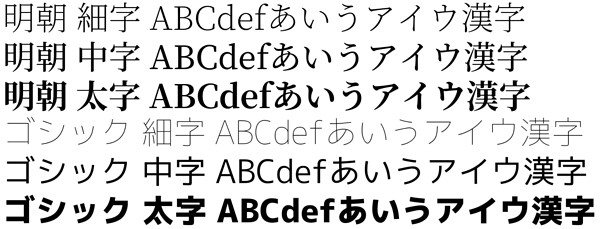